In [1]:
import ROOT
import ostap.fixes.fixes
from ostap.core.core import cpp, Ostap
from ostap.core.core import pwd, cwd, ROOTCWD
from ostap.core.core import rootID, funcID, funID, fID, histoID, hID, dsID
from ostap.core.core import VE
from ostap.histos.histos import h1_axis, h2_axes, h3_axes
from ostap.histos.graphs import makeGraph, hToGraph, hToGraph2, hToGraph3, lw_graph
import ostap.trees.trees
import ostap.trees.cuts
import ostap.histos.param
import ostap.histos.compare
import ostap.io.root_file
import ostap.math.models
import ostap.fitting.roofit 
import ostap.fitting.models as Models

Welcome to JupyROOT 6.20/06


In [8]:
sig_file = ROOT.TFile("sig.root","READ")
bkg_file = ROOT.TFile("bkg.root","READ")
mix_file = ROOT.TFile("mix.root","READ")
sig_file.ls()

TFile**		sig.root	
 TFile*		sig.root	
  KEY: TTree	treeS;1	treeS


In [9]:
tSig = sig_file.treeS
tBkg = bkg_file.treeB
tMix = mix_file.treeM

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


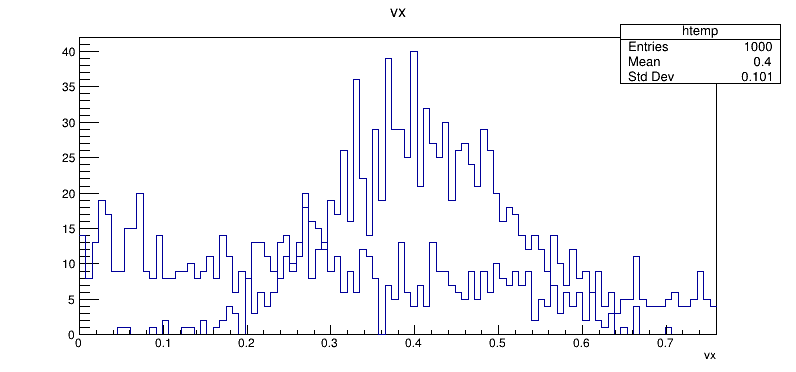

In [10]:
canv = ROOT.TCanvas("canv","canv",800,400)
tSig.draw("vx")
tBkg.draw("vx","","same")
canv.Draw()

In [14]:
from ostap.tools.tmva import Trainer , Reader

# ostap.tools.tmva                 INFO    Trainer(TestTMVA):         variables: ('vx', 'vy')
# ostap.tools.tmva                 INFO    Trainer(TestTMVA): Configuration    :``nTrain_Signal=0:nTrain_Background=0:SplitMode=Random:NormMode=NumEvents''
# ostap.tools.tmva                 INFO    Trainer(TestTMVA): Train    all methods ('MLP', 'BDTG', 'Cuts', 'Fisher', 'Likelihood') 
# ostap.tools.tmva                 INFO    Trainer(TestTMVA): Test     all methods ('MLP', 'BDTG', 'Cuts', 'Fisher', 'Likelihood') 
# ostap.tools.tmva                 INFO    Trainer(TestTMVA): Evaluate all methods ('MLP', 'BDTG', 'Cuts', 'Fisher', 'Likelihood') 
# ostap.tools.tmva                 INFO    Trainer(TestTMVA):      variables: ('vx', 'vy')
# ostap.tools.tmva                 INFO    Trainer(TestTMVA): Weights files : ('TestTMVA/weights/TestTMVA_BDTG.weights.xml', 'TestTMVA/weights/TestTMVA_MLP.weights.xml', 'TestTMVA/weights/TestTMVA_Fisher.weights.xml', 'TestTMVA/weights/TestTMVA_Cuts.weights.xml',

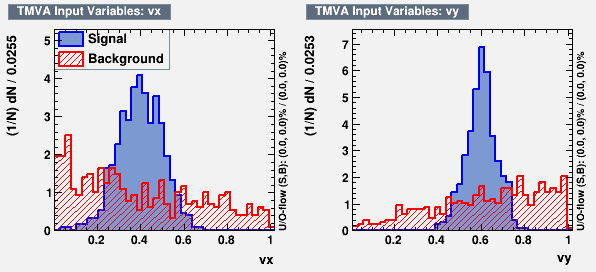

In [29]:
trainer = Trainer (
   name    = 'TestTMVA' ,   
   methods = [
   # type                   name   configuration
   ( ROOT.TMVA.Types.kMLP        , 'MLP'        , 'H:!V:EstimatorType=CE:VarTransform=N:NCycles=200:HiddenLayers=N+3:TestRate=5:!UseRegulator' ) ,
   ( ROOT.TMVA.Types.kBDT        , 'BDTG'       , 'H:!V:NTrees=100:MinNodeSize=2.5%:BoostType=Grad:Shrinkage=0.10:UseBaggedBoost:BaggedSampleFraction=0.5:nCuts=20:MaxDepth=2' ) ,
   ( ROOT.TMVA.Types.kCuts       , 'Cuts'       , 'H:!V:FitMethod=MC:EffSel:SampleSize=200000:VarProp=FSmart' ) ,
   ( ROOT.TMVA.Types.kFisher     , 'Fisher'     , 'H:!V:Fisher:VarTransform=None:CreateMVAPdfs:PDFInterpolMVAPdf=Spline2:NbinsMVAPdf=50:NsmoothMVAPdf=10' ),
   ( ROOT.TMVA.Types.kLikelihood , 'Likelihood' , 'H:!V:TransformOutput:PDFInterpol=Spline2:NSmoothSig[0]=20:NSmoothBkg[0]=20:NSmoothBkg[1]=10:NSmooth=1:NAvEvtPerBin=50' )
   ] ,
   variables  = [ 'vx' , 'vy' ] , ## Variables to be used for training 
   signal     = tSig                       , ## ``Signal'' sample 
   background = tBkg                       , ## ``Background'' sample  
   verbose    = False )
weights_files = trainer.train ()

In [31]:
reader = Reader( 
   'MyCut' ,
   variables     = [ ('vx' , lambda s : s.vx )   ,
                     ('vy' , lambda s : s.vy )   ] ,
  weights_files = trainer.tar_file  )

# ostap.tools.tmva                 INFO    TMVA Reader(MyCut) booked methods are ('BDTG', 'MLP', 'Fisher', 'Cuts', 'Likelihood')


create data set info Default


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv2
Warning in <TROOT::Append>: Replacing existing TH1: h_bdt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mlp (Potential memory leak).


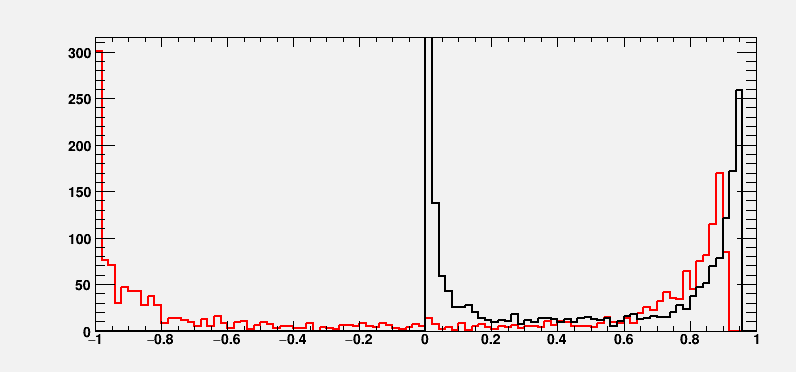

In [37]:
canv2 = ROOT.TCanvas("canv2","canv2",800,400)
h_bdt = ROOT.TH1F("h_bdt","",100,-1,1)
h_bdt.red()
h_mlp = ROOT.TH1F("h_mlp","",100,-1,1)
bdt  = reader['BDTG']                     ## get  one method
mlp  = reader['MLP']                     ## get  one method
for ev in tMix :                          ## loop over the entries 
    h_bdt.Fill(bdt(ev))
    h_mlp.Fill(mlp(ev))
h_bdt.Draw()
h_mlp.Draw("same")
#print(tMix)
#tMix.draw("vx")
canv2.Draw()

In [63]:
mlp_cut = 0.55
ok = 0
fn = 0
fp=0
bg=0
ii=0
for ev in tMix :                          ## loop over the entries 
    ii+=1
    if mlp(ev)>mlp_cut:
        if ev.tr>0.5:
            ok+=1
        else:
            fp+=1
    else:
        if ev.tr>0.5:
            fn+=1
        else:
            bg+=1
print(ii)
print("Ok             " + str(ok))
print("False positive " + str(fp))
print("False negative " + str(fn))
print("GOOD bkg       " + str(bg))

2000
Ok             904
False positive 131
False negative 96
GOOD bkg       869
